In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cartopy.feature as cfeature
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import seaborn as sns
import geopandas as gpd

ERROR 1: PROJ: proj_create_from_database: Open of /home/k16v981/.conda/envs/my_env/share/proj failed


In [2]:
mon_precip_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_precip_sa.nc')

mon_precip_sa['date'] = pd.to_datetime(mon_precip_sa['date'].values.astype(str), format='%Y%m%d')

lat_min, lat_max = -26.25, -12 
lon_min, lon_max = 16, 32.25

mon_precip_zambia = mon_precip_sa.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

mon_precip_zambia_coarsened = mon_precip_zambia.coarsen(latitude=2, longitude=2, boundary = 'exact').mean()

feb_precip_zambia = mon_precip_zambia_coarsened.sel(date=(mon_precip_sa['date.month'] == 2))

oct_precip_zambia = mon_precip_zambia_coarsened.sel(date=(mon_precip_sa['date.month'] == 10))

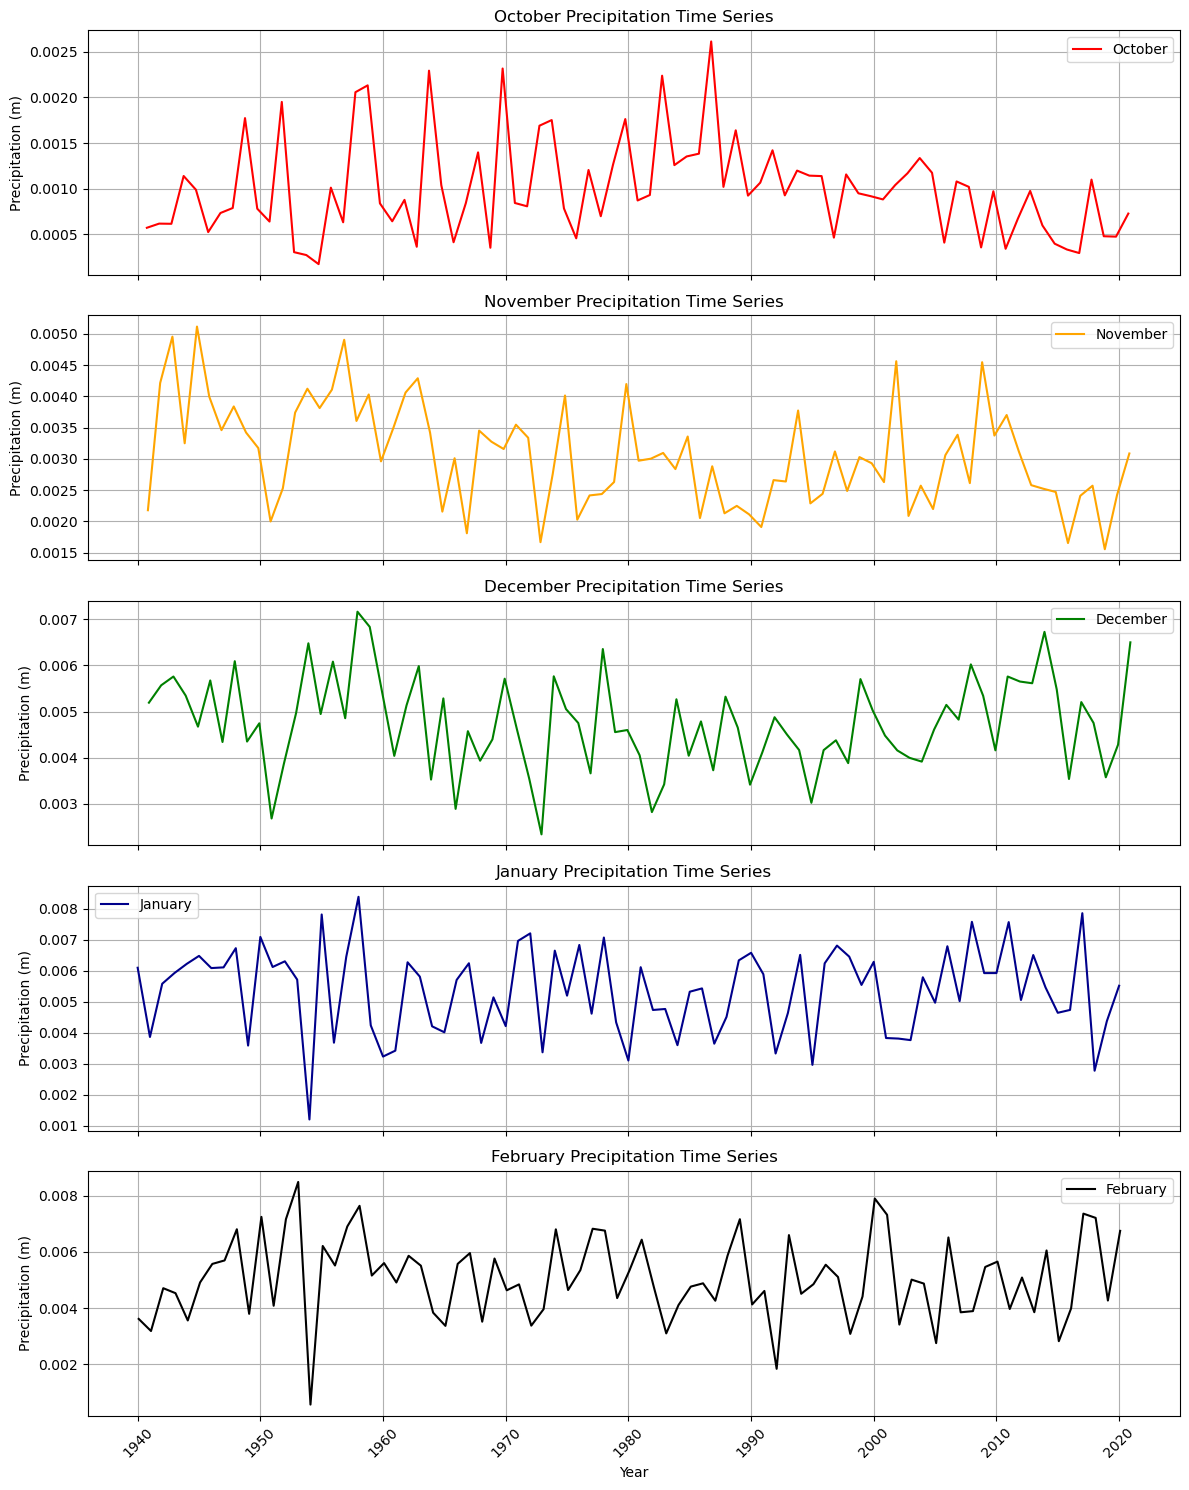

In [3]:
months = [10, 11, 12, 1, 2]
month_names = ['October', 'November', 'December', 'January', 'February']
color = ['red', 'orange', 'green', 'darkblue', 'black']

# Step 4: Create a figure with subplots
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True)

mean_mon_precip_zambia = mon_precip_zambia.mean(dim=['latitude', 'longitude'])

# Step 5: Loop over each month and plot
for i, month in enumerate(months):
    # Select the data for the specific month
    month_data = mean_mon_precip_zambia.sel(date=mean_mon_precip_zambia['date.month'] == month)

    # Plot the time series for the month
    axs[i].plot(month_data['date'], month_data['tp'], label=month_names[i], color = color[i])
    axs[i].set_title(f'{month_names[i]} Precipitation Time Series')
    axs[i].set_ylabel('Precipitation (m)')
    axs[i].grid()
    axs[i].legend()

# Step 6: Format the x-axis
axs[-1].set_xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('/home/k16v981/my_work/figures/southern_africa/oct_feb_zambia_precip.jpg', format='jpg')

plt.show()

In [4]:
precip = feb_precip_zambia['tp'].values

def fit_arima_to_grid_point(data):
    try:
        
        # Check for stationarity
        result = adfuller(data)
        if result[1] > 0.05:  # Non-stationary
            data = data.diff().dropna()

        # Fit ARIMA model automatically
        model = pm.auto_arima(data, seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True)
        
        
        # Forecasting
        forecast = model.predict(n_periods=12)
        return forecast, model.order
    except Exception as e:
        print(f"Error fitting model: {e}")
        return None, None

In [5]:
forecasts = np.full((precip.shape[1], precip.shape[2], 12), np.nan)
parameters = np.empty((precip.shape[1], precip.shape[2], 3), dtype=float)

In [6]:
# Loop through grid points
for i in range(precip.shape[1]):
    for j in range(precip.shape[2]):
        time_series_data = precip[:, i, j]
        forecast, order = fit_arima_to_grid_point(time_series_data)
        forecasts[i, j, :] = forecast
        parameters[i, j, :] = order if order is not None else [np.nan, np.nan, np.nan]


Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'


In [7]:
mean_forecasts = np.nanmean(forecasts, axis=2)

mean_precip = np.nanmean(precip, axis=0)

latitudes = feb_precip_zambia['latitude'].values
longitudes = feb_precip_zambia['longitude'].values

mean_forecasts = xr.DataArray(mean_forecasts, coords={'lat': latitudes, 'lon': longitudes}, dims=['lat', 'lon'])

/tmp/ipykernel_1192299/1252175015.py:1: RuntimeWarning: Mean of empty slice
  mean_forecasts = np.nanmean(forecasts, axis=2)


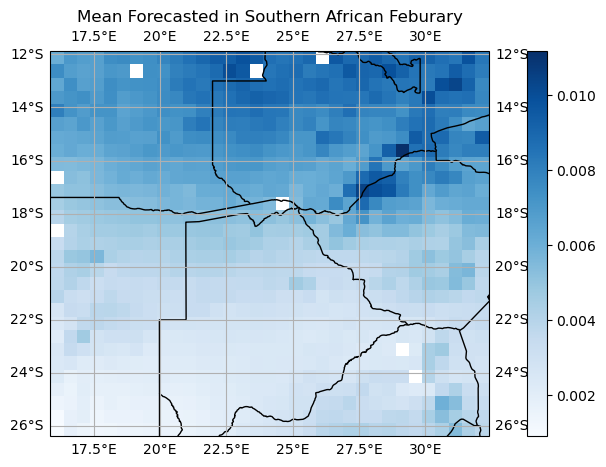

In [8]:
# Make plot
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 3: Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)

mean_forecasts.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')

# Step 5: Show the plot
plt.title('Mean Forecasted in Southern African Feburary')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/feb_arima_fc_precip.jpg', format='jpg')

plt.show()

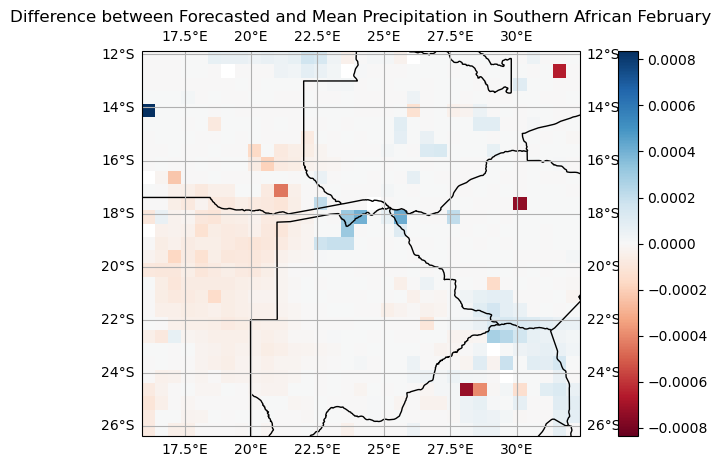

In [9]:
# Calculate mean precipitation in Febs

# Calculate the difference between mean forecast and mean precipitation
difference = mean_forecasts - mean_precip

# Create a heatmap for the differences
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 3: Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)

difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu')

# Step 5: Show the plot
plt.title('Difference between Forecasted and Mean Precipitation in Southern African February')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/feb_arima_fc_precip_diff.jpg', format='jpg')

plt.show()

In [10]:
precip = oct_precip_zambia['tp'].values

for i in range(precip.shape[1]):
    for j in range(precip.shape[2]):
        time_series_data = precip[:, i, j]
        forecast, order = fit_arima_to_grid_point(time_series_data)
        forecasts[i, j, :] = forecast
        parameters[i, j, :] = order if order is not None else [np.nan, np.nan, np.nan]

Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has 

In [11]:
mean_forecasts = np.nanmean(forecasts, axis=2)

mean_precip = np.nanmean(precip, axis=0)

latitudes = feb_precip_zambia['latitude'].values
longitudes = feb_precip_zambia['longitude'].values

mean_forecasts = xr.DataArray(mean_forecasts, coords={'lat': latitudes, 'lon': longitudes}, dims=['lat', 'lon'])

/tmp/ipykernel_1192299/1252175015.py:1: RuntimeWarning: Mean of empty slice
  mean_forecasts = np.nanmean(forecasts, axis=2)


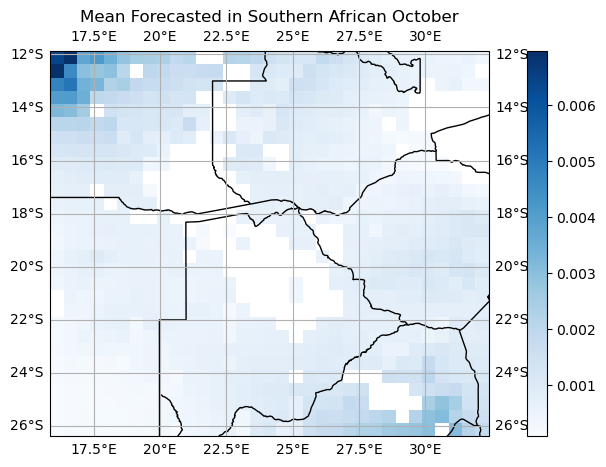

In [12]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 3: Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)

mean_forecasts.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')

# Step 5: Show the plot
plt.title('Mean Forecasted in Southern African October')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/oct_arima_fc_precip.jpg', format='jpg')
plt.show()

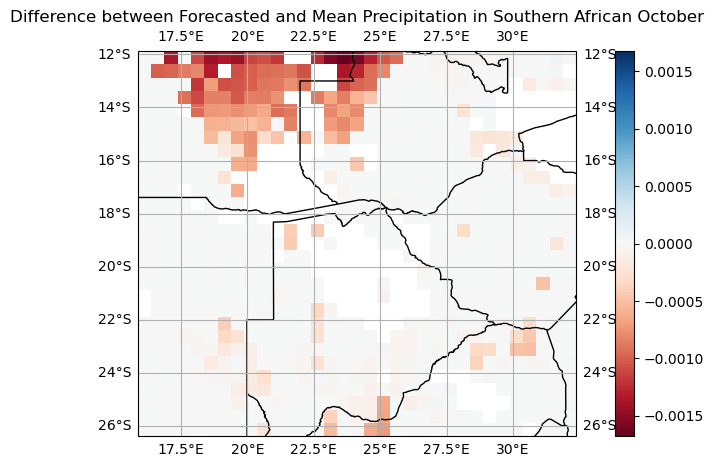

In [13]:
# Calculate the difference between mean forecast and mean precipitation
difference = mean_forecasts - mean_precip

# Create a heatmap for the differences
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 3: Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)

difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu')

# Step 5: Show the plot
plt.title('Difference between Forecasted and Mean Precipitation in Southern African October')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/oct_arima_fc_precip_diff.jpg', format='jpg')

plt.show()

In [14]:
nov_precip_zambia = mon_precip_zambia_coarsened.sel(date=(mon_precip_sa['date.month'] == 11))
precip = nov_precip_zambia['tp'].values

for i in range(precip.shape[1]):
    for j in range(precip.shape[2]):
        time_series_data = precip[:, i, j]
        forecast, order = fit_arima_to_grid_point(time_series_data)
        forecasts[i, j, :] = forecast
        parameters[i, j, :] = order if order is not None else [np.nan, np.nan, np.nan]

Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has 

/home/k16v981/.conda/envs/my_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/k16v981/.conda/envs/my_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [15]:
mean_forecasts = np.nanmean(forecasts, axis=2)

mean_precip = np.nanmean(precip, axis=0)

latitudes = feb_precip_zambia['latitude'].values
longitudes = feb_precip_zambia['longitude'].values

mean_forecasts = xr.DataArray(mean_forecasts, coords={'lat': latitudes, 'lon': longitudes}, dims=['lat', 'lon'])

/tmp/ipykernel_1192299/1252175015.py:1: RuntimeWarning: Mean of empty slice
  mean_forecasts = np.nanmean(forecasts, axis=2)


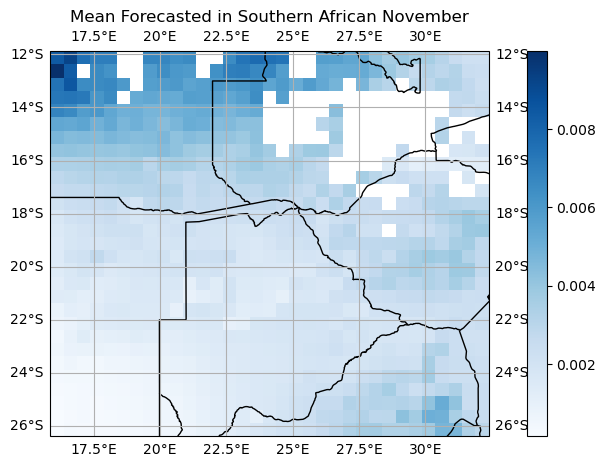

In [16]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 3: Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)

mean_forecasts.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')

# Step 5: Show the plot
plt.title('Mean Forecasted in Southern African November')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/nov_arima_fc_precip.jpg', format='jpg')

plt.show()

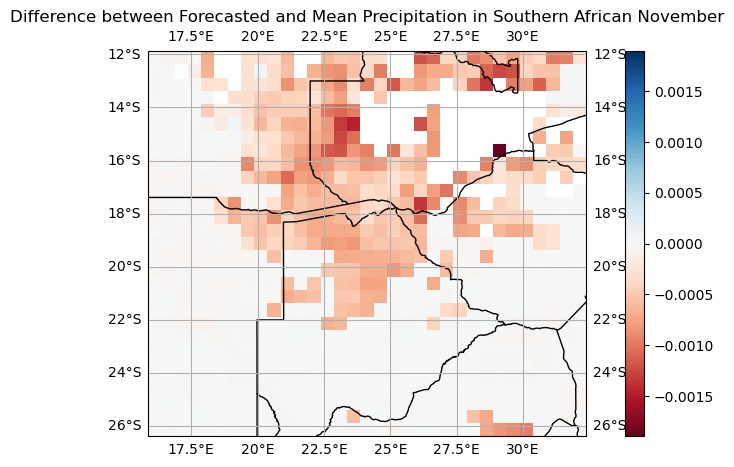

In [17]:
# Calculate the difference between mean forecast and mean precipitation
difference = mean_forecasts - mean_precip

# Create a heatmap for the differences
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 3: Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)

difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu')

# Step 5: Show the plot
plt.title('Difference between Forecasted and Mean Precipitation in Southern African November')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/nov_arima_fc_precip_difference.jpg', format='jpg')
plt.show()

In [18]:
dec_precip_zambia = mon_precip_zambia_coarsened.sel(date=(mon_precip_sa['date.month'] == 12))
precip = dec_precip_zambia['tp'].values

for i in range(precip.shape[1]):
    for j in range(precip.shape[2]):
        time_series_data = precip[:, i, j]
        forecast, order = fit_arima_to_grid_point(time_series_data)
        forecasts[i, j, :] = forecast
        parameters[i, j, :] = order if order is not None else [np.nan, np.nan, np.nan]

Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has 

In [19]:
mean_forecasts = np.nanmean(forecasts, axis=2)

mean_precip = np.nanmean(precip, axis=0)

latitudes = feb_precip_zambia['latitude'].values
longitudes = feb_precip_zambia['longitude'].values

mean_forecasts = xr.DataArray(mean_forecasts, coords={'lat': latitudes, 'lon': longitudes}, dims=['lat', 'lon'])

/tmp/ipykernel_1192299/1252175015.py:1: RuntimeWarning: Mean of empty slice
  mean_forecasts = np.nanmean(forecasts, axis=2)


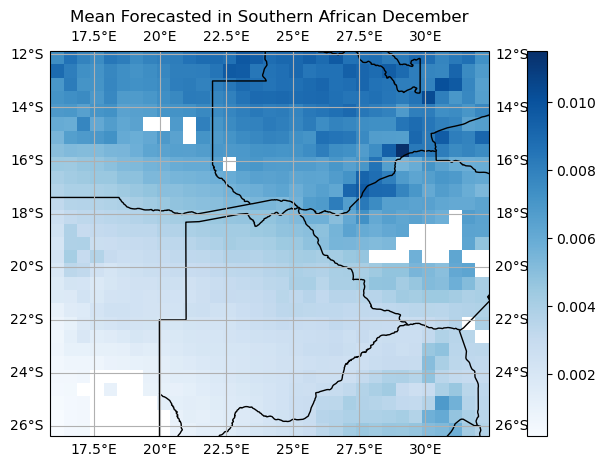

In [20]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 3: Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)

mean_forecasts.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')

# Step 5: Show the plot
plt.title('Mean Forecasted in Southern African December')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/dec_arima_fc_precip.jpg', format='jpg')

plt.show()

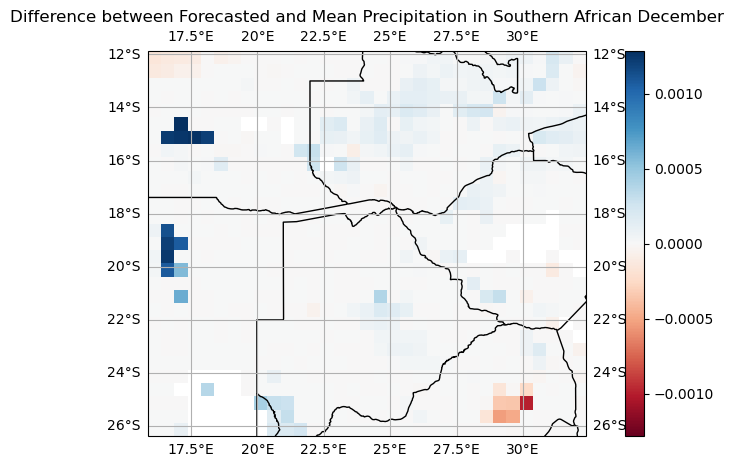

In [21]:
# Calculate the difference between mean forecast and mean precipitation
difference = mean_forecasts - mean_precip

# Create a heatmap for the differences
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 3: Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)

difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu')

# Step 5: Show the plot
plt.title('Difference between Forecasted and Mean Precipitation in Southern African December')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/dec_arima_fc_precip_difference.jpg', format='jpg')
plt.show()

In [22]:
jan_precip_zambia = mon_precip_zambia_coarsened.sel(date=(mon_precip_sa['date.month'] == 1))
precip = jan_precip_zambia['tp'].values

for i in range(precip.shape[1]):
    for j in range(precip.shape[2]):
        time_series_data = precip[:, i, j]
        forecast, order = fit_arima_to_grid_point(time_series_data)
        forecasts[i, j, :] = forecast
        parameters[i, j, :] = order if order is not None else [np.nan, np.nan, np.nan]

Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'
Error fitting model: 'numpy.ndarray' object has no attribute 'diff'


In [23]:
mean_forecasts = np.nanmean(forecasts, axis=2)

mean_precip = np.nanmean(precip, axis=0)

latitudes = feb_precip_zambia['latitude'].values
longitudes = feb_precip_zambia['longitude'].values

mean_forecasts = xr.DataArray(mean_forecasts, coords={'lat': latitudes, 'lon': longitudes}, dims=['lat', 'lon'])

/tmp/ipykernel_1192299/1252175015.py:1: RuntimeWarning: Mean of empty slice
  mean_forecasts = np.nanmean(forecasts, axis=2)


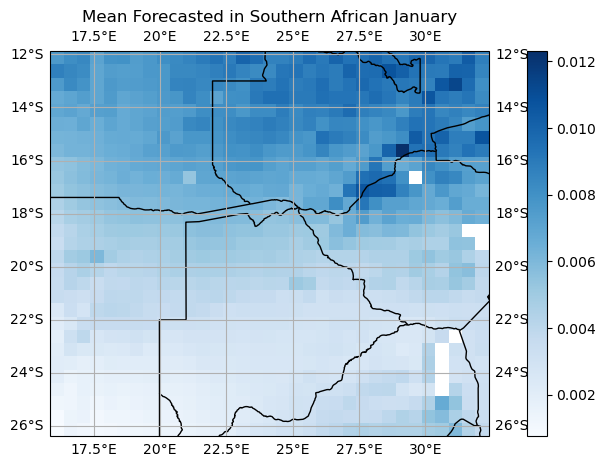

In [24]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 3: Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)

mean_forecasts.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')

# Step 5: Show the plot
plt.title('Mean Forecasted in Southern African January')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/jan_arima_fc_precip.jpg', format='jpg')

plt.show()

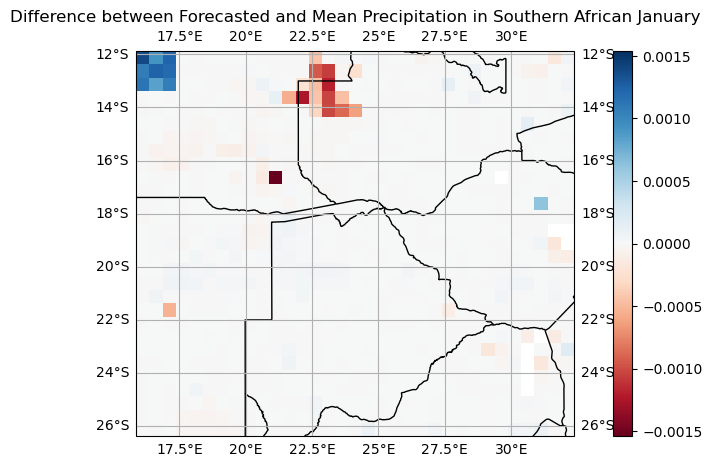

In [25]:
# Calculate the difference between mean forecast and mean precipitation
difference = mean_forecasts - mean_precip

# Create a heatmap for the differences
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 3: Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)

difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu')

# Step 5: Show the plot
plt.title('Difference between Forecasted and Mean Precipitation in Southern African January')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/jan_arima_fc_precip_difference.jpg', format='jpg')
plt.show()